# Visualization with *yt* and Napari Part 1: fixed resolution regions

In this notebook series, we'll explore some ways to use [napari](https://napari.org/) to interactively visualize data loaded and sampled with [*yt*](yt-project.org/).

The inspiration for this series came from watching 'Interactive Image Processing at Scale' from the folks at Coiled and guests Nicholas Sofroniew and Talley Lambert, who presented their work on using napari and dask to load and process multi-resolution images of cells (check out the video [here](https://youtu.be/KG_ye5qzFmk)). In it, Sofroniew and Lambert present some surprisingly simple notebooks that leverage dask's lazy loading and block mapping to define loading and processing functions that get triggered on demand by napari as the user needs it. 

In this notebook, we'll keep things fairly simple and first focus on in-memory visualization in which we use *yt* to generate a 3D image that is then visualized with napari. We'll then look at an example using dask to lazily load *yt* slices.

##  general approach

Ultimately, loading data into napari is as simple as:

```
viewer = napari.view_image(image_stack)
```

where `image_stack` is an array object. We'll start with the simplest case in which `image_stack` is an in-memory image array generated by storing images created from *yt* slices and then demonstrate a lazy loading approach with dask. 


## required packages

Running this notebook requires *yt*, napari and dask in addition to stanard packages from the scipy stack (numpy, matplotlib). 


## imports 

So let's start off by setting up the `qt` environment needed by napari:

In [1]:
 # for napari, do it first!
%gui qt

and import all the packages we'll use

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt 
import os

# yt related
import yt
from yt.units import kpc

# napari related imports 
import napari
from napari.utils import nbscreenshot
import logging

# dask imports 
from dask import delayed
import dask.array as da

## Test data 

We'll use a standard *yt* test ENZO dataset, `IsolatedGalaxy`, (download [here](http://yt-project.org/data/IsolatedGalaxy.tar.gz)).

So let's first load up the data and slice at a fixed `z` value as usual in *yt*: 

In [3]:
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030") 

yt : [INFO     ] 2020-09-08 11:40:42,765 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2020-09-08 11:40:42,766 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-09-08 11:40:42,766 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-09-08 11:40:42,767 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-09-08 11:40:42,767 Parameters: cosmological_simulation   = 0.0


Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 18802.20it/s]
yt : [INFO     ] 2020-09-08 11:40:42,788 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2020-09-08 11:40:43,931 xlim = 0.490001 0.509999
yt : [INFO     ] 2020-09-08 11:40:43,932 ylim = 0.490001 0.509999
yt : [INFO     ] 2020-09-08 11:40:43,932 xlim = 0.490001 0.509999
yt : [INFO     ] 2020-09-08 11:40:43,933 ylim = 0.490001 0.509999
yt : [INFO     ] 2020-09-08 11:40:43,934 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



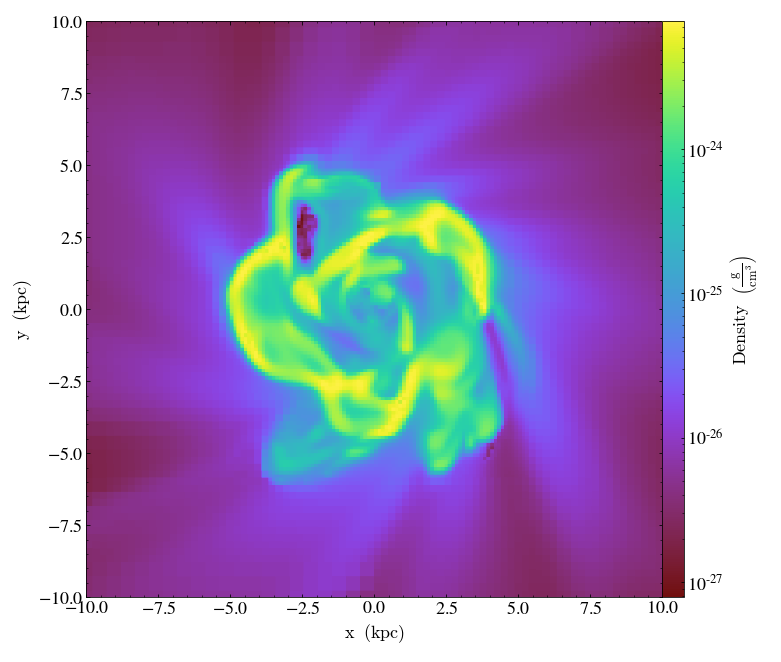

In [4]:
slc = yt.SlicePlot(ds, 'z', 'density', center=[0.5, 0.5, 0.5],width=(20,'kpc'))
slc.show()

## Loading in-memory *yt* Fixed Resolution Region into napari

In order to load *yt* images into napari, we need to be able to create a numpy array to pass to napari. Perhaps the simplest way is to extract a [Fixed Resolution Region](https://yt-project.org/doc/analyzing/objects.html#selecting-fixed-resolution-regions). 

To extract the log of the density over the whole domain at a resolution of 300x300x300 pixels: 

In [5]:
cg = ds.r[::300j,::300j,::300j]
dens_log = np.log10(cg['density'])
print(dens_log.shape)
print(type(dens_log))

(300, 300, 300)
<class 'numpy.ndarray'>


`dens_log` here is an in-memory numpy array that we can simply load into napari. To do so, we first launch a napari viewer and then add `dens_log` as an image layer:

In [6]:
viewer = napari.Viewer()

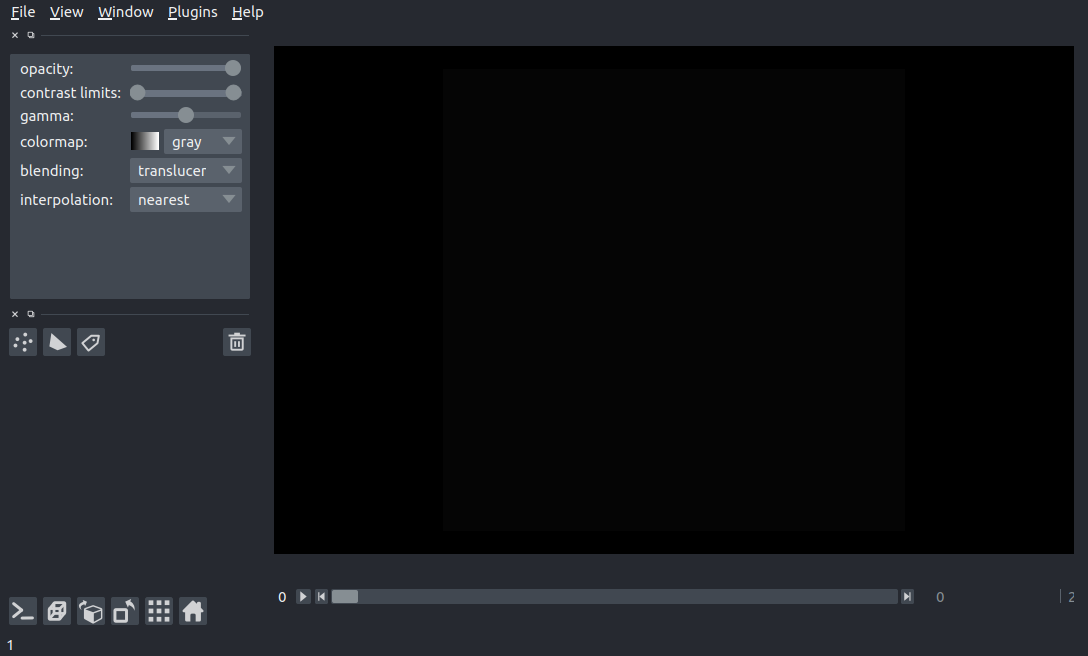

In [7]:
viewer.add_image(dens_log)
nbscreenshot(viewer)

Moving the slider will vary the first dimension of the array that we're slicing along, we can also use napari's color map selector and 3d rendering:

<video controls src="resources/napari_1.mp4" />


### Assembling a 3D array from 2D slices

We can also assemble a 3D array to visualize by concatenating 2D slices. The main reason to take this approach is that it is easily extendible to a dask lazy-loading process, which we'll explore later on. So that we have a more interesting view, we'll pull out slices focused on the dataset's center.

Let's start by creating a function to slice the data set at a given `x` location and return an image array:

In [8]:
def return_x_slice(xval,res,c,hwid):    
    # return a slice at a single xvalue
    # xval: the xvalue in kpc to slice at 
    # res: the resolution of the image array at xval 
    # c: the center of the image in kpc
    # hwid: the half-width of the image in kpc
    region = ds.r[(xval,'kpc'), (c-hwid,'kpc'):(c+hwid,'kpc'):res*1j,
              (c-hwid,'kpc'):(c+hwid,'kpc'):res*1j]
    return np.log10(region['density'])

and define the range we want to slice over:

In [9]:
res = 300
c = 500. # center of slices in kpc
hwid = 25. # half width of region to slice in kpc 
xvals = np.linspace(c-hwid,c+hwid,res)

before assembling the array, we'll turn off the yt logging so we're not overwhelmed by output:

In [10]:
yt.funcs.mylog.setLevel(50)

Now we'll assemble the array (this is what we'll "daskify" in a later notebook):

In [11]:
%%time
dens_log_2 = np.array([return_x_slice(xval,res,c,hwid) for xval in xvals])
dens_log_2.shape

CPU times: user 16.6 s, sys: 907 ms, total: 17.5 s
Wall time: 17.7 s


(300, 300, 300)

and add it to the viewer:

In [12]:
viewer.add_image(dens_log_2)

<Image layer 'dens_log_2' at 0x7f445291f490>

<video controls src="resources/napari_2.mp4" />

## Lazy-loading with Dask

The most obvious way to leverage dask in this process is to transform the image frame loop into a stack of lazy dask processes, so that napari generates each frame as it's selected. The approach is outlined in napari's documentation [here](https://napari.org/tutorials/applications/dask.html) as well as Lambert's [napari-dask-example notebook](https://github.com/tlambert03/napari-dask-example/blob/master/dask_napari.ipynb).

First, we pull out out a sample frame and wrap the `return_x_slice` function with the `dask.delayed` function:

In [13]:
sample = return_x_slice(xvals[0],res,c,hwid)
lazy_x_frame = delayed(return_x_slice)  # our lazy "reader"

Now we need to build up our lazy loaded arrays into an image stack: 

In [14]:
lazy_arrays = [lazy_x_frame(xval,res,c,hwid) for xval in xvals]
dask_arrays = [
    da.from_delayed(lazy_array, shape=sample.shape, dtype=sample.dtype)
    for lazy_array in lazy_arrays
]

From which we build up a single dask array stack:

In [15]:
dask_stack = da.stack(dask_arrays, axis=0)
dask_stack

,Array,Chunk
Bytes,216.00 MB,720.00 kB
Shape,"(300, 300, 300)","(1, 300, 300)"
Count,900 Tasks,300 Chunks
Type,float64,numpy.ndarray


And now we can just add the `dask_stack` to a napari viewer. 

In [16]:
try: 
    viewer.close()
except:
    pass
viewer = napari.Viewer()
viewer.add_image(dask_stack)

<Image layer 'dask_stack' at 0x7f44808bcc50>

Now when we move the slider, napari will traverse the `x` slices, loading them as needed:

<video controls src="resources/napari_2pt5.mp4" />

One caveat to this approach is that the we're restricted to 2D slices -- switching to a 3D rendering would require loading the entire cube into memory (this is why we closed any existing napari viewer first). And in the above case, where our total 3D image array would only use 218 Mb, we're probably better off just loading into memory. So let's look at a case where loading into memory would be potentially problematic. We'll also slice along a different dimension, so let's create a new function to wrap:

In [17]:
def return_z_slice(zval,res,c,hwid):    
    # return a slice at a single zvalue 
    # zval: the zvalue in kpc to slice at 
    # res: the resolution of the image array at xval 
    # c: the center of the image in kpc
    # hwid: the half-width of the image in kpc
    region = ds.r[(c-hwid,'kpc'):(c+hwid,'kpc'):res*1j,
              (c-hwid,'kpc'):(c+hwid,'kpc'):res*1j,
              (zval,'kpc')]
    return np.log10(region['density'])

Now let's bump up the resolution and width of the image then set up the dask stack as before:

In [18]:
res = 2000
hwid = 500
zvals = np.linspace(c-hwid,c+hwid,res)
sample = return_z_slice(zvals[0],res,c,hwid)
lazy_z_frame = delayed(return_z_slice)  # our lazy "reader"

lazy_arrays = [lazy_z_frame(zval,res,c,hwid) for zval in zvals]
dask_arrays = [
    da.from_delayed(lazy_array, shape=sample.shape, dtype=sample.dtype)
    for lazy_array in lazy_arrays
]

dask_stack = da.stack(dask_arrays, axis=0)
dask_stack

,Array,Chunk
Bytes,64.00 GB,32.00 MB
Shape,"(2000, 2000, 2000)","(1, 2000, 2000)"
Count,6000 Tasks,2000 Chunks
Type,float64,numpy.ndarray


In this case we'd need 64 Gb to load this image array into memory while each frame is only 32 Mb.

In [19]:
try: 
    viewer.close()
except:
    pass
viewer = napari.Viewer()
viewer.add_image(dask_stack)

<Image layer 'dask_stack' at 0x7f4452a4b690>

<video controls src="resources/napari_3.mp4" />

Now we can see a small lag when we move the slider, but it's still quick enough to be a more than acceptable tradeoff when considering how few of us have computers that would have 64 Gb of memory to spare for loading the dataset into memory. 

## Extra fun!

As a final section, let's load up a different dataset that has more complex 3D structures, the `Enzo_64` test dataset (download [here](http://yt-project.org/data/Enzo_64.tar.gz), 2.4 Gb): 

Parsing Hierarchy : 100%|██████████| 752/752 [00:00<00:00, 20682.60it/s]



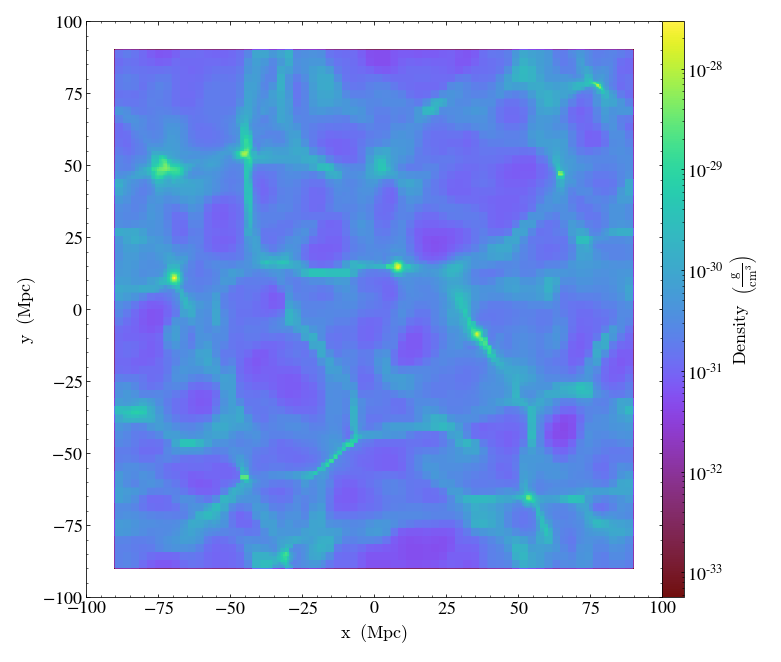

In [20]:
ds = yt.load("Enzo_64/DD0043/data0043")
slc = yt.SlicePlot(ds, 'z', 'density', center=[.5,.5,.5],width=(200,'Mpc'))
slc.show()

and extract a fixed resolution region covering the whole dataset with 300 pixels in each dimension:

In [21]:
cg = ds.r[::300j,::300j,::300j]
dens_log = np.log10(cg['density'])

and launch a new viewer:

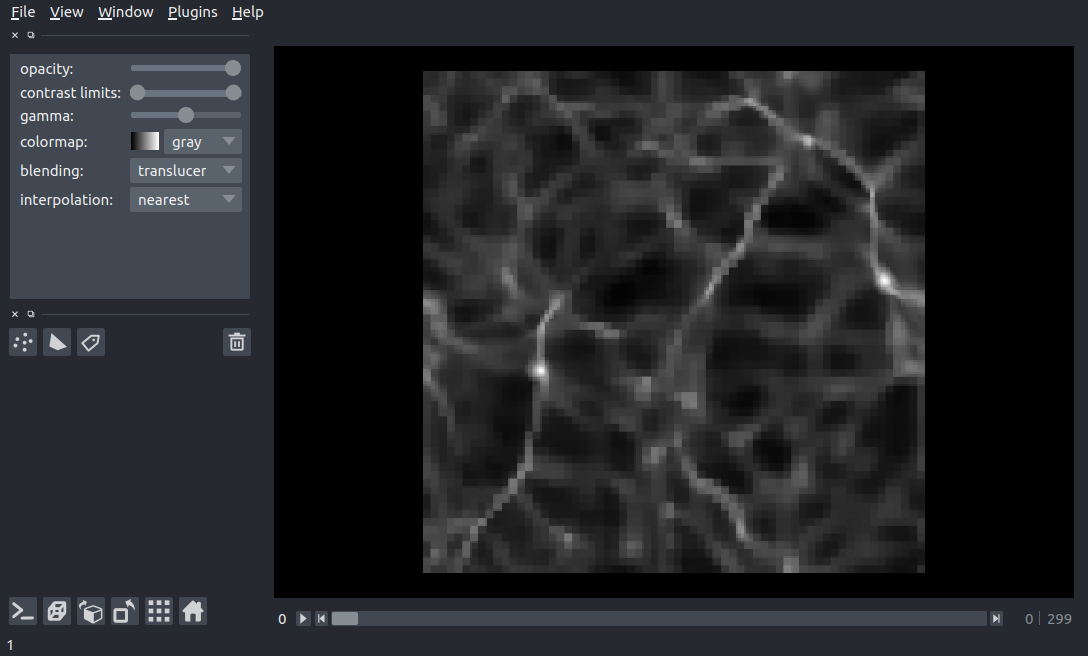

In [22]:
try: 
    viewer.close()
except:
    pass
viewer = napari.Viewer()
viewer.add_image(dens_log)
nbscreenshot(viewer)

<video controls src="resources/napari_4.mp4" />

## Final Thoughts

In this notebook we've demonstrated some simple approaches to loading image arrays from *yt* datasets into napari, providing a quick method for interactive visualization of *yt* datasets. In putting together this notebook, I've been impressed by just how **easy** all of this is. By stringing together 3 different open source projects across the python ecosystem, we have instant support for wider audiences than each package has alone: *yt* users can explore their data in more interactive ways and napari users can essentially use *yt* as a back end data visualizer for any of the data formats supported by *yt*, all beneath the dask umbrella!

In future notebooks, we'll explore some more ways to use napari for visualization of *yt* datasets, so stay tuned! 